<a href="https://colab.research.google.com/github/NatBrian/chatgpt-from-scratch/blob/main/nanochat_zero_to_hero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Modern Large Language Model from Scratch

**Objective:** We will build a Generative Pre-trained Transformer (GPT) from scratch. This is the same technology behind ChatGPT.

**No prior knowledge required.** We will explain every concept as if you are new to AI.

## Table of Contents

| Stage | Topic | What we are building |
|-------|-------|----------------------|
| 0 | Setup | Preparing our tools |
| 1 | Bigram Model | A model that guesses the next word based on just one word |
| 2 | Tokenization | Converting words into numbers the computer understands |
| 3 | Attention | Giving the model 'memory' to look at previous words |
| 4 | Modern Components | Upgrading the engine with 2024 technology (Llama 3) |
| 5 | Full GPT Model | Assembling the robot |
| 6 | Training | Teaching the robot to read and write |
| 7 | Inference & Chat | Talking to our creation |
| 8 | RLHF Alignment | Teaching the robot manners |
| 9 | Alignment | Making the assistant safe and helpful (RLHF) |

---


## Stage 0: Setup

Before we build, we need tools. We will use **PyTorch**, which is a library that helps us do the heavy math required for AI.

We also need a **GPU** (Graphics Processing Unit). Think of a CPU (your computer's main brain) as a math professor—very smart but does one problem at a time. A GPU is like a thousand elementary school students—they can solve thousands of simple problems at the exact same time. AI needs this parallel speed.


In [1]:
# Setup local checkpoint directory
# Since we are not using Google Drive, we will save files locally.
# WARNING: These files will be DELETED if the Colab runtime disconnects.
import os
PROJECT_DIR = "checkpoints"
os.makedirs(PROJECT_DIR, exist_ok=True)
print(f"Local checkpoint directory created at: {PROJECT_DIR}")
print("Remember to DOWNLOAD your checkpoint file ('ckpt.pt') to your computer to save your progress!")


Local checkpoint directory created at: checkpoints
Remember to DOWNLOAD your checkpoint file ('ckpt.pt') to your computer to save your progress!


In [2]:
# Install the necessary libraries.
# 'torch': The framework for building neural networks.
# 'tiktoken': A tool from OpenAI to turn text into numbers.
# 'datasets': A library to download books and text for training.
!pip install -q torch tiktoken datasets matplotlib

import torch
import torch.nn as nn
from torch.nn import functional as F
import math, time

# Check if we have a GPU available.
# 'cuda' means we have an NVIDIA GPU. 'cpu' means we are using the slow processor.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


## Stage 1: The Simplest Language Model (Bigram)

### What is a Language Model?
A language model is just a machine that plays a guessing game. You give it a sequence of words, and it guesses what comes next.

**Example:** "The cat sat on the _____."
You probably guessed "mat" or "floor". That's because you have a language model in your brain.

### The Bigram Model
We will start with the simplest possible version: a **Bigram Model**.

**Simple Explanation: The Forgetful Guesser**
This model is very forgetful. It looks **only at the very last word** to guess the next one. It ignores everything else.

- Input: "The cat sat on the"
- Bigram sees only: "the"
- Bigram guesses: "end" (because "the end" is common)

It has no memory of the "cat" or the "sitting". Let's build it to see how bad it is.

**Theoretical Motivation: Markov Chains**
The Bigram model is a **First-Order Markov Chain**.
It assumes that the probability of the next word depends *only* on the current word:
$$ P(w_t | w_{t-1}, w_{t-2}, ...) \approx P(w_t | w_{t-1}) $$
This is a massive simplification, which is why it's not very smart.

In [3]:
# Download a small dataset (Shakespeare) to practice on.
!wget -q https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()
print(f"Dataset length: {len(text):,} characters")
print("First 200 characters:")
print(text[:200])


Dataset length: 1,115,394 characters
First 200 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [4]:
# Computers cannot understand letters like 'a' or 'b'. They only understand numbers.
# We need a 'Tokenizer' to convert characters into integers.

# 1. Find all unique characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# 2. Create a map from character to integer (stoi) and integer to character (itos)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

# 3. Define helper functions to convert back and forth
encode = lambda s: [stoi[c] for c in s] # Text -> Numbers
decode = lambda l: ''.join([itos[i] for i in l]) # Numbers -> Text

print(f"Vocabulary size: {vocab_size} unique characters")
print(f"Example: 'hello' becomes {encode('hello')}")


Vocabulary size: 65 unique characters
Example: 'hello' becomes [46, 43, 50, 50, 53]


In [5]:
# Convert the entire text into a long list of numbers (tensor)
data = torch.tensor(encode(text), dtype=torch.long)

# Split into training (90%) and validation (10%) sets.
# We train on the 90% and test on the 10% to make sure the model isn't just memorizing.
n = int(0.9 * len(data))
train_data, val_data = data[:n], data[n:]


block_size = 8   # The maximum number of characters we look at (context)
batch_size = 32  # How many independent sequences we process at once (parallelism)

# --- Visualizing a Batch ---
# Imagine a batch_size of 4 and block_size of 8:
# Row 1: [The, cat, sat, on, the, mat, ., <End>]
# Row 2: [Hello, world, this, is, AI, !, <Pad>, <Pad>]
# Row 3: [A, B, C, D, E, F, G, H]
# Row 4: [1, 2, 3, 4, 5, 6, 7, 8]
# We process ALL 4 rows at the exact same time!

def get_batch(split):
    # Pick a random chunk of data
    d = train_data if split == 'train' else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))

    # x is the input, y is the target (the very next character)
    x = torch.stack([d[i:i+block_size] for i in ix])
    y = torch.stack([d[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)


### Understanding Inputs (x) and Targets (y)

We train the model by showing it a sequence and asking it to predict the next character.

If the text is "Hello":
- When input is `[H]`, target is `e`
- When input is `[H, e]`, target is `l`
- When input is `[H, e, l]`, target is `l`

We do this for every position simultaneously.


In [6]:
class BigramModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # The Embedding layer is a lookup table.
        # For every input number, it looks up a list of probabilities for the next number.
        self.embed = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # idx is the input numbers (Batch, Time)
        logits = self.embed(idx)
        loss = None

        if targets is not None:
            # If we have targets, calculate how wrong we are (loss)
            B, T, C = logits.shape
            # Reshape to match what PyTorch expects
            # We flatten the Batch (B) and Time (T) dimensions because PyTorch's cross_entropy
            # expects a long list of predictions, not a grid.
            # (B, T, C) -> (B*T, C)
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new):
        # This function generates new text
        for _ in range(max_new):
            # Get predictions
            logits, _ = self(idx)
            # Focus only on the last time step (Bigram only cares about the last token)
            logits = logits[:, -1, :]
            # Convert scores to probabilities
            probs = F.softmax(logits, dim=-1)
            # Sample the next character from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append to the sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

bigram = BigramModel(vocab_size).to(device)
print(f"Model parameters: {sum(p.numel() for p in bigram.parameters()):,}")


Model parameters: 4,225


In [7]:
# Let's see what the untrained model generates.
# Since it hasn't learned anything, it should just be random gibberish.
print("Output BEFORE training:")
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(bigram.generate(context, 100)[0].tolist()))


Output BEFORE training:

hF$X?&JdA rRNFwe&NcMVeHDwqcRsIVRzZ:z?GFqBoBak3hpbv$I!t?cxhQp'Wuyf;IGQP?EMFyoxjkFxNcD? ,3NTbwiZI S
Ji


### Visualizing Softmax: From Scores to Probabilities

The model outputs **Logits** (raw scores). These can be negative, huge, or tiny.
We use the **Softmax** function to turn them into **Probabilities** (percentages that sum to 100%).

Let's see how this works visually.


In [ ]:
# --- Scaffolding: Visualizing Softmax ---
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Imagine the model predicts the next character.
# It gives raw scores (logits) for 'A', 'B', 'C', 'D'
logits = torch.tensor([2.0, 1.0, 0.1, -1.0])
labels = ['A', 'B', 'C', 'D']

# Apply Softmax
probs = F.softmax(logits, dim=-1)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Logits (Raw Scores)
axes[0].bar(labels, logits.numpy(), color='gray')
axes[0].set_title("Raw Logits (Scores)")
axes[0].set_ylabel("Value")
axes[0].grid(True, alpha=0.3)

# Plot 2: Probabilities (Softmax)
axes[1].bar(labels, probs.numpy(), color='skyblue')
axes[1].set_title("Probabilities (Softmax)")
axes[1].set_ylabel("Probability (0-1)")
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)

for i, p in enumerate(probs):
    axes[1].text(i, p.item() + 0.02, f"{p.item():.2f}", ha='center')

plt.show()
print(f"Logits: {logits.tolist()}")
print(f"Probs:  {probs.tolist()} (Sum: {probs.sum():.1f})")


In [46]:
# Create an optimizer.
# The optimizer is the algorithm that updates the model's numbers to reduce the error (loss).
optimizer = torch.optim.AdamW(bigram.parameters(), lr=1e-3)

print("Starting training loop...")
for step in range(1000):
    # 1. Get a batch of data
    xb, yb = get_batch('train')

    # 2. Forward pass: Make predictions and calculate loss
    _, loss = bigram(xb, yb)

    # 3. Backward pass: Calculate gradients (how to change weights)
    # (We will explain exactly how this "Mountain Descent" works in Stage 6!)
    optimizer.zero_grad()
    loss.backward()

    # 4. Update weights
    optimizer.step()

    if step % 200 == 0: print(f"Step {step}: loss={loss.item():.4f}")

print(f"Final loss: {loss.item():.4f}")


Starting training loop...
Step 0: loss=2.7920
Step 200: loss=2.4781
Step 400: loss=2.4391
Step 600: loss=2.2932
Step 800: loss=2.6141
Final loss: 2.2772


## Interlude: How Machines Actually Learn (Forward & Backward)

You just saw `loss.backward()` and `optimizer.step()`. But what is actually happening?

### The Cycle of Learning
1.  **Forward Pass (The Guess):** The model looks at the input and makes a guess.
2.  **Loss Calculation (The Score):** We compare the guess to the real answer.
3.  **Backward Pass (The Blame Game):** We calculate **Gradients**. A gradient tells us: *"If I increase this specific number in the model, will the error go up or down?"*
4.  **Optimizer Step (The Fix):** We nudge every number in the opposite direction of the gradient to reduce the error.

### Visualizing the Math
Let's look at a tiny, manual example to see the numbers change.


In [ ]:
# --- Scaffolding: Manual Backpropagation ---
import torch

# 1. Initialize a "Weight" (The model's brain)
# Let's say we want to learn the number 10.
# We start with a random guess: 2.0
weight = torch.tensor([2.0], requires_grad=True)

# 2. The Training Loop (Manual)
print(f"Goal: 10.0")
print(f"Starting Weight: {weight.item()}")

for i in range(4):
    # Forward Pass: Our simple model is just "Output = Weight * 3"
    # (Imagine input is always 3, and we want output to be 30)
    input_val = 3.0
    target = 30.0
    
    output = weight * input_val
    
    # Calculate Loss (Mean Squared Error)
    loss = (output - target)**2
    
    # Backward Pass (Calculate Gradient)
    loss.backward()
    
    # Update Weight
    # We move the weight in the opposite direction of the gradient
    learning_rate = 0.1
    with torch.no_grad():
        weight -= learning_rate * weight.grad
        
        # Reset gradient for next step
        weight.grad.zero_()
        
    print(f"Step {i+1}: Output={output.item():.1f}, Loss={loss.item():.1f}, New Weight={weight.item():.1f}")

print("See how the weight moved from 2.0 towards 10.0?")


In [57]:
# Now let's generate text again.
# It should look slightly better (maybe like real words), but still nonsensical
# because it only looks at one character at a time.
print("Output AFTER training:")
context = torch.zeros((1,1), dtype=torch.long, device=device)
print(decode(bigram.generate(context, 200)[0].tolist()))


Output AFTER training:


hit That he sour, I bawig, ste thin th I s idicen tain take!
WYor atore mee layearung abeves
Ongrekl,
Fis.
de n min win It wnyouy tte
TIFFSerer s to angind f dist
YOuleinithellld.
VNIOLAn?
Ar wn w ty


### Section Summary: Stage 1

**What we learned:**
1.  **Training Loop:** The cycle of Guess -> Measure Error -> Update Weights.
2.  **Limitation:** The Bigram model is too simple. It has no "memory". It sees "t" and guesses "h", but it doesn't know if the previous word was "ca" (cat) or "ba" (bat).

**Next Step:** We need a model that can look back at the entire history of words. That is what **Attention** does.


## Stage 2: Tokenization

In Stage 1, we used characters (a, b, c). But modern models like GPT-4 don't read letters; they read **tokens**.

### Why not characters?
If we use characters, the model has to learn that 't', 'h', 'e' always go together. That's a waste of time.

### Why not whole words?
There are too many words in English. The vocabulary would be huge (millions).

### The Solution: Byte Pair Encoding (BPE)
BPE is a middle ground. It groups common pairs of letters together.
- "ing" becomes one token.
- "the" becomes one token.
- Rare words like "Zylophone" might be split into "Zy", "lo", "phone".

We will use `tiktoken`, the exact tokenizer used by OpenAI.

**Simple Explanation: LEGO Bricks**
- **Characters (a, b, c)** are like dust. Too small to build with.
- **Words (Apple, Run)** are like pre-assembled castles. Too specific.
- **Tokens** are like LEGO bricks. They are the standard building blocks. "ing", "the", "pre" are reusable pieces that can build any word.

**Theoretical Motivation: Data Compression (BPE)**
We use **Byte Pair Encoding (BPE)**. It is an iterative data compression algorithm.
1.  Start with individual characters.
2.  Find the most frequent pair (e.g., "t" + "h").
3.  Merge them into a new token ("th").
4.  Repeat until you reach the desired vocabulary size (e.g., 50,304).
This balances vocabulary size with sequence length.

In [10]:
import tiktoken

# Load the tokenizer used by GPT-2 (and GPT-3)
enc = tiktoken.get_encoding("gpt2")

text = "Hello, I am learning AI!"
tokens = enc.encode(text)

print(f"Original text: {text}")
print(f"Token IDs: {tokens}")
print(f"Compression: {len(text)} characters -> {len(tokens)} tokens")

# Let's see what each token represents
for t in tokens:
    print(f"  Token {t} -> '{enc.decode([t])}'")


Original text: Hello, I am learning AI!
Token IDs: [15496, 11, 314, 716, 4673, 9552, 0]
Compression: 24 characters -> 7 tokens
  Token 15496 -> 'Hello'
  Token 11 -> ','
  Token 314 -> ' I'
  Token 716 -> ' am'
  Token 4673 -> ' learning'
  Token 9552 -> ' AI'
  Token 0 -> '!'


In [11]:
# We wrap the tokenizer in a class to make it easy to use later.
class Tokenizer:
    def __init__(self):
        self.enc = tiktoken.get_encoding("gpt2")
        self.vocab_size = 50304  # Standard GPT-2 vocabulary size

    def encode(self, text):
        # Convert string to list of integers (tensor)
        return torch.tensor(self.enc.encode(text), dtype=torch.long)

    def decode(self, tokens):
        # Convert list of integers back to string
        if isinstance(tokens, torch.Tensor): tokens = tokens.tolist()
        return self.enc.decode(tokens)

tokenizer = Tokenizer()
print(f"Vocabulary size: {tokenizer.vocab_size:,} tokens")


Vocabulary size: 50,304 tokens


### Section Summary: Stage 2

**What we learned:**
- **Tokens** are the atoms of language for AI.
- **BPE** allows us to represent text efficiently.

Now that we have proper data, let's build the brain.


## Interlude: The Semantic Space (Real Embeddings)

**Simple Explanation: The Meaning Map**
Imagine a giant map of a city.
- Words with similar meanings (like "King" and "Queen") live in the same neighborhood.
- Unrelated words (like "Apple") live on the other side of town.
The model learns these locations automatically.

**Theoretical Motivation: Distributed Representation**
We map discrete tokens (integers) to a continuous vector space $\mathbb{R}^d$.
The geometric distance (e.g., Cosine Similarity) between two vectors corresponds to their semantic similarity.
This allows the model to generalize: if it learns something about "Dog", it automatically knows it might apply to "Cat" too.

In [ ]:
# --- Scaffolding: Visualizing the Semantic Space (Concept) ---
import matplotlib.pyplot as plt

# Since we can't run t-SNE on a fresh model (it takes time and data),
# let's visualize the *concept* of what embeddings try to achieve.

# Imagine 2D coordinates for words
words = {
    "King":  [0.9, 0.9],
    "Queen": [0.8, 0.85],
    "Man":   [0.9, 0.2],
    "Woman": [0.8, 0.15],
    "Apple": [0.1, 0.5],
    "Car":   [-0.5, -0.2]
}

plt.figure(figsize=(6, 6))
# Plot points
for word, (x, y) in words.items():
    plt.scatter(x, y, s=100, c='skyblue', edgecolors='black')
    plt.text(x+0.05, y, word, fontsize=12)

# Draw "Vector Arithmetic" arrow
# King - Man + Woman ~ Queen
plt.arrow(0.9, 0.9, 0, -0.7, head_width=0.02, color='gray', linestyle='--', length_includes_head=True) # King -> Man
plt.text(0.95, 0.55, "- Man", color='gray')

plt.arrow(0.9, 0.2, -0.1, -0.05, head_width=0.02, color='gray', linestyle='--', length_includes_head=True) # Man -> Woman (shift)
plt.text(0.85, 0.1, "+ Woman", color='gray')

plt.title("Conceptual Embedding Space
(Similar words are close together)")
plt.grid(True, alpha=0.3)
plt.xlim(-0.8, 1.2)
plt.ylim(-0.5, 1.2)
plt.show()

print("In a real model, these are 384-dimensional vectors, not 2D.")
print("But the math works the same way!")


In [ ]:
# Inspecting Real Embeddings
import matplotlib.pyplot as plt

# 1. Instantiate a real Embedding Layer
vocab_size = 50304
n_embd = 384 # The dimension used in our config
embedding_layer = nn.Embedding(vocab_size, n_embd)

# 2. Get the vector for a specific token
token_id = tokenizer.encode("Hello")[0]
vector = embedding_layer(torch.tensor([token_id]))

# 3. Visualize it
plt.figure(figsize=(10, 2))
plt.imshow(vector.detach().numpy(), aspect='auto', cmap='viridis')
plt.title(f"The 'Meaning' of 'Hello' (Token {token_id})\n(384 dimensions)")
plt.xlabel("Feature Dimension")
plt.yticks([])
plt.colorbar(label="Activation Value")
plt.show()

print(f"Shape: {vector.shape}")
print("This 'Barcode' is how the model sees the word. Similar words will eventually have similar barcodes.")


## Stage 3: Attention (The Heart of Transformers)

This is the most important concept in modern AI.

**The Problem:** In a sentence like *"The bank was closed because it was flooded"*, how does the machine know that "it" refers to "bank" and not "closed"?

**The Solution:** **Self-Attention**. Every word looks at every other word and decides how relevant it is.
- "it" asks: "What am I?"
- "bank" answers: "I am a noun, and I can be flooded."
- "it" decides: "Okay, I am referring to the bank."

We will build this mechanism in 4 steps.


### Version 1: The Naive Approach (Averaging)

The simplest way to get context is to just **average** the features of all previous words.
If I am at word 5, I take the average of words 1, 2, 3, 4, and 5.

This is weak (it loses order information), but it's a start.


In [12]:
torch.manual_seed(42)
B, T, C = 4, 8, 2  # Batch=4, Time=8, Channels=2
x = torch.randn(B, T, C)

# We want x[b,t] to be the average of x[b, 0...t]
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        # Slice all previous tokens and average them
        xbow[b, t] = x[b, :t+1].mean(dim=0)

print("Example row 0 (original):", x[0,0])
print("Example row 1 (average of 0 and 1):", xbow[0,1])


Example row 0 (original): tensor([1.9269, 1.4873])
Example row 1 (average of 0 and 1): tensor([ 1.4138, -0.3091])


### Version 2: Matrix Multiplication (Efficiency)

Loops in Python are slow. We can do the exact same averaging using **Matrix Multiplication**.
We create a triangular matrix of 1s and normalize it. When we multiply our data by this matrix, it automatically computes the running averages.


In [13]:
# Create a lower triangular matrix of 1s
wei = torch.tril(torch.ones(T, T))
# Normalize so rows sum to 1
wei = wei / wei.sum(1, keepdim=True)

print("Weight matrix (notice the lower triangle):")
print(wei)

# Perform matrix multiplication
xbow2 = wei @ x
print(f"\nDoes it match the loop version? {torch.allclose(xbow, xbow2)}")


Weight matrix (notice the lower triangle):
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

Does it match the loop version? True


#### Connection: From Loops to Matrices
**Why did we switch to matrices?**
Version 1 (Loops) and Version 2 (Matrix Multiplication) do the **exact same math**.
- **Version 1** calculates the average one by one.
- **Version 2** calculates all averages at once using a "Lower Triangular Matrix".

Let's visualize this matrix to see how it "selects" the past.


In [ ]:
# Visualize the Lower Triangular Matrix (The "Averaging Machine")
import matplotlib.pyplot as plt
import torch

T = 8
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)

plt.figure(figsize=(6, 6))
plt.imshow(wei.numpy(), cmap='Blues')
plt.title("The 'Averaging' Matrix (Version 2)\nEach row sums to 1.0")
plt.xlabel("Past Tokens")
plt.ylabel("Current Token")
plt.colorbar(label="Weight")
plt.show()
print("Notice: Each row includes the current token and all previous tokens with equal weight.")


### Version 3: Softmax (Making it smart)

Averaging is boring. We want the model to **choose** which past words are important.

We use **Softmax**. Softmax takes a list of numbers and turns them into probabilities (they sum to 1).
We also use a **Mask** (setting future positions to negative infinity) so the model can't cheat and look at the future.


In [14]:
# Start with zeros (no preference yet)
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))

# Masking: Set future positions to -infinity
# When we take softmax, e^-inf becomes 0. This prevents looking ahead.
wei = wei.masked_fill(tril == 0, float('-inf'))

# Softmax normalizes the weights
wei = F.softmax(wei, dim=-1)

print("Weights after softmax:")
print(wei)

xbow3 = wei @ x
print(f"Matches? {torch.allclose(xbow, xbow3)}")


Weights after softmax:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
Matches? True


#### Connection: Adding the Probabilistic Layer
**How does this connect to Version 2?**
In Version 2, the weights were fixed (hard-coded).
In **Version 3**, we introduce **Softmax**.
- Softmax turns any numbers into probabilities (0.0 to 1.0).
- By using `-inf` (negative infinity) as a mask, we force the Softmax to give **zero** probability to future tokens.

This structure is the **skeleton** of the Transformer. It's still doing simple averaging for now, but it's ready to accept "smart" scores in the next step.


In [ ]:
# Visualize the Softmax Masking
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

T = 8
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float('-inf')) # The "Mask"
probs = F.softmax(wei, dim=-1) # The "Softmax"

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: The Raw Mask
im1 = ax[0].imshow(wei.numpy(), cmap='coolwarm')
ax[0].set_title("Step 1: The Mask (-inf for future)")
plt.colorbar(im1, ax=ax[0])

# Plot 2: The Resulting Probabilities
im2 = ax[1].imshow(probs.numpy(), cmap='Blues')
ax[1].set_title("Step 2: Softmax (Uniform Probabilities)")
plt.colorbar(im2, ax=ax[1])

plt.show()


### Version 4: Self-Attention (The Real Deal)

**Simple Explanation: The Library Search**
- **Query (Q):** What you are looking for ("dinosaurs").
- **Key (K):** The label on the book spine ("Paleontology").
- **Value (V):** The content inside the book.
The attention score is how well your Query matches the Key. If it matches, you get the Value.

**Theoretical Motivation: Content-Based Addressing**
Attention is a weighted average of values $V$, where weights are determined by the compatibility between the query $Q$ and keys $K$.
$$ 	{Attention}(Q, K, V) = 	{softmax}\left(\frac{QK^T}{\sqrt{d_k}}
\right)V $$
This allows the model to dynamically route information based on content rather than fixed position.

In [15]:
torch.manual_seed(42)
B, T, C = 4, 8, 32
x = torch.randn(B, T, C)
head_size = 16

# Three linear layers to generate Q, K, V
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

# Generate Q, K, V from the input x
k, q, v = key(x), query(x), value(x)

# Calculate scores: Query dot Key
# (B, T, 16) @ (B, 16, T) -> (B, T, T)
# 1. Calculate raw affinity scores
wei = q @ k.transpose(-2, -1) 

# 2. Scale by sqrt(head_size) to keep gradients stable
wei = wei * (head_size ** -0.5)

# 3. Masking (don't look at future)
# We replace future positions with negative infinity.
# When we do Softmax later, exp(-inf) becomes 0.
wei = wei.masked_fill(torch.tril(torch.ones(T,T)) == 0, float('-inf'))

# Softmax to get probabilities
wei = F.softmax(wei, dim=-1)

# Aggregate values based on attention weights
out = wei @ v

print("Learned attention weights (first batch):")
print(wei[0])


Learned attention weights (first batch):
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4106, 0.5894, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3657, 0.2283, 0.4061, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2168, 0.2759, 0.2204, 0.2870, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2553, 0.1697, 0.1548, 0.2341, 0.1861, 0.0000, 0.0000, 0.0000],
        [0.1318, 0.2060, 0.1405, 0.1917, 0.1949, 0.1351, 0.0000, 0.0000],
        [0.2137, 0.0978, 0.2374, 0.1025, 0.1418, 0.0838, 0.1230, 0.0000],
        [0.0852, 0.1047, 0.0824, 0.1376, 0.1015, 0.1900, 0.1780, 0.1206]],
       grad_fn=<SelectBackward0>)


#### Connection: The "Brain" Arrives
**The Final Leap**
Version 3 gave us the structure (Mask + Softmax).
**Version 4** gives us the **Intelligence**.

Instead of starting with zeros (uniform attention), we calculate **Affinity Scores** using Queries and Keys.
- **Query (Q):** What I'm looking for.
- **Key (K):** What I contain.
- **Score = Q @ K:** How much I should pay attention.

Below, notice how the heatmap is no longer uniform! The model is *choosing* which words matter.


### Visualizing Attention

Let's look at the "Heatmap".
- The **x-axis** is the token being looked at.
- The **y-axis** is the token doing the looking.
- **Color intensity** shows how much attention is being paid.

Notice the triangle shape? That's the causal mask. You can't look at the future!


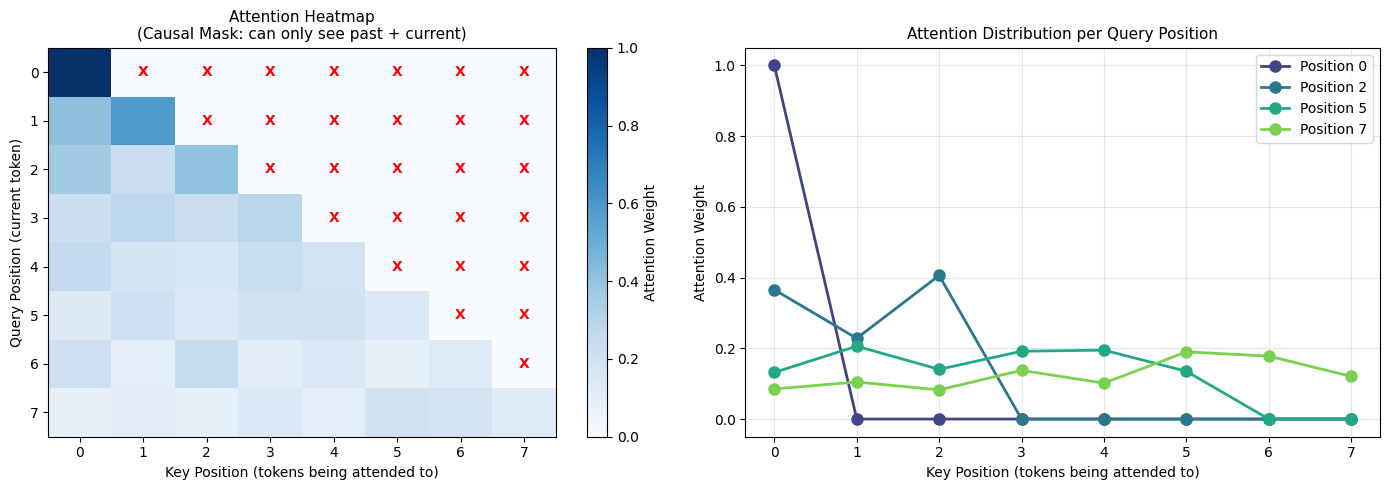

Key observations:
1. Lower-triangular pattern: Can only attend to past + current (causal mask)
2. Position 0 attends ONLY to itself (weight = 1.0)
3. Later positions can distribute attention across more tokens
4. Each row sums to 1.0 (softmax normalization)

Row sums: ['1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00']


In [16]:
import matplotlib.pyplot as plt

# Visualize attention weights for batch 0
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Attention heatmap
ax1 = axes[0]
attn_weights = wei[0].detach().numpy()  # Shape: (T, T)
im1 = ax1.imshow(attn_weights, cmap='Blues', aspect='auto')
ax1.set_xlabel('Key Position (tokens being attended to)', fontsize=10)
ax1.set_ylabel('Query Position (current token)', fontsize=10)
ax1.set_title('Attention Heatmap\n(Causal Mask: can only see past + current)', fontsize=11)
ax1.set_xticks(range(T))
ax1.set_yticks(range(T))
plt.colorbar(im1, ax=ax1, label='Attention Weight')

# Add visual markers for masked positions
for i in range(T):
    for j in range(T):
        if j > i:  # Masked (future) positions
            ax1.text(j, i, 'X', ha='center', va='center', color='red', fontsize=10, fontweight='bold')

# Plot 2: Line plot showing attention distribution per position
ax2 = axes[1]
colors = plt.cm.viridis([0.2, 0.4, 0.6, 0.8])
positions_to_show = [0, 2, 5, 7]
for idx, pos in enumerate(positions_to_show):
    ax2.plot(range(T), attn_weights[pos, :], 'o-', color=colors[idx],
             label=f'Position {pos}', linewidth=2, markersize=8)
ax2.set_xlabel('Key Position (tokens being attended to)', fontsize=10)
ax2.set_ylabel('Attention Weight', fontsize=10)
ax2.set_title('Attention Distribution per Query Position', fontsize=11)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(T))
ax2.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("Key observations:")
print("1. Lower-triangular pattern: Can only attend to past + current (causal mask)")
print("2. Position 0 attends ONLY to itself (weight = 1.0)")
print("3. Later positions can distribute attention across more tokens")
print("4. Each row sums to 1.0 (softmax normalization)")
print(f"\nRow sums: {[f'{s:.2f}' for s in attn_weights.sum(axis=1)]}")

### Deep Dive: Inspecting the Real Tensors

Instead of a toy example, let's look at the **actual numbers** inside the tensors we just calculated (`q`, `k`, `wei`).

We will take the last token in the sequence (Token 7) and see how it calculates its attention scores against all previous tokens (0-7).


In [ ]:
# Real-time Inspection of the Attention Mechanism
import matplotlib.pyplot as plt

# Detach tensors to convert to numpy (from the cell above)
q_real = q[0].detach().numpy() # Batch 0
k_real = k[0].detach().numpy() # Batch 0
wei_real = wei[0].detach().numpy() # Batch 0

# Let's focus on the last token (Time=7)
token_idx = 7
query_vector = q_real[token_idx] # The vector "looking"
key_vectors = k_real             # The vectors "being looked at"

# Calculate dot products manually to prove the math
dot_products = (key_vectors @ query_vector) * (head_size ** -0.5)

plt.figure(figsize=(12, 5))

# Plot 1: The Query Vector (What we are looking for)
plt.subplot(1, 2, 1)
plt.title(f"Real Query Vector (Token {token_idx})", fontsize=12)
plt.imshow(query_vector.reshape(1, -1), cmap='coolwarm', aspect='auto')
plt.yticks([])
plt.xlabel("Head Dimension (Features)")
plt.colorbar(label="Value", orientation='horizontal')

# Plot 2: The Resulting Scores
plt.subplot(1, 2, 2)
plt.title(f"Attention Scores for Token {token_idx}", fontsize=12)
plt.bar(range(len(dot_products)), dot_products, color='gray', alpha=0.5, label='Raw Dot Product')
plt.plot(wei_real[token_idx], color='red', marker='o', linewidth=2, label='Final Probability (Softmax)')

plt.xlabel("Target Token Index")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Left: The actual 32 numbers representing the Query.")
print("Right: How those numbers matched with the Keys (Gray Bars) and the final Attention (Red Line).")


### Why do we divide by sqrt(head_size)?

This is a technical detail called **Scaling**.
If we don't divide, the numbers in the dot product get huge. When numbers are huge, Softmax becomes extremely "peaky" (one value is 1, the rest are 0).
This kills the gradient (the signal for learning). Scaling keeps the numbers in a nice range so the model can learn smoothly.


Raw variance: 74.0 (grows with dimension!)
Scaled variance: 1.2 (stable around 1.0)



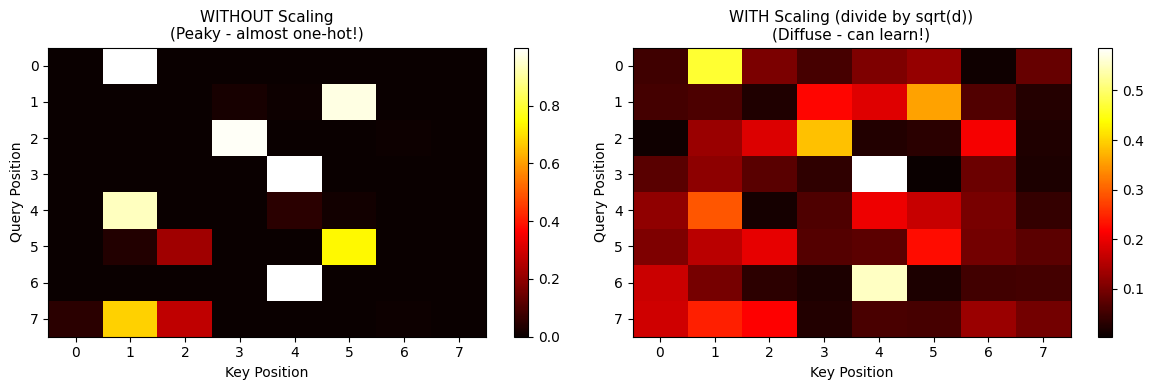

Without scaling: Network is 'overconfident' before learning!
With scaling: Attention is diffuse, allowing gradients to flow and learn.


In [17]:
# Demonstrate the scaling problem visually
q_demo, k_demo = torch.randn(8, 64), torch.randn(8, 64)
raw = q_demo @ k_demo.T
scaled = raw * (64 ** -0.5)

print(f"Raw variance: {raw.var():.1f} (grows with dimension!)")
print(f"Scaled variance: {scaled.var():.1f} (stable around 1.0)")
print()

# Visualize the effect on softmax
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Without scaling
raw_probs = F.softmax(raw, dim=-1).detach().numpy()
im1 = axes[0].imshow(raw_probs, cmap='hot', aspect='auto')
axes[0].set_title('WITHOUT Scaling\n(Peaky - almost one-hot!)', fontsize=11)
axes[0].set_xlabel('Key Position')
axes[0].set_ylabel('Query Position')
plt.colorbar(im1, ax=axes[0])

# With scaling
scaled_probs = F.softmax(scaled, dim=-1).detach().numpy()
im2 = axes[1].imshow(scaled_probs, cmap='hot', aspect='auto')
axes[1].set_title('WITH Scaling (divide by sqrt(d))\n(Diffuse - can learn!)', fontsize=11)
axes[1].set_xlabel('Key Position')
axes[1].set_ylabel('Query Position')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print("Without scaling: Network is 'overconfident' before learning!")
print("With scaling: Attention is diffuse, allowing gradients to flow and learn.")

### Section Summary: Stage 3

**What we learned:**
- **Self-Attention** allows tokens to talk to each other.
- **Q, K, V** is the mechanism: Query matches Key to get Value.
- **Masking** ensures we generate text one word at a time without cheating.

We now have the brain. Let's upgrade it.


## Stage 4: Modern Components (Llama 3)

The original Transformer was invented in 2017. AI moves fast. We will use the modern improvements found in **Llama 3 (2024)**.

1.  **RMSNorm:** A simpler, faster way to normalize numbers.
2.  **RoPE:** A better way to handle position (angles instead of addition).
3.  **SwiGLU:** A more expressive neuron activation function.


### 4.1 RMSNorm (Root Mean Square Normalization)

**Simple Explanation: Volume Control**
Imagine you are listening to a playlist. Some songs are very quiet, and some are extremely loud. If a song is too loud, it hurts your ears (in AI, this "exploding" signal breaks the model). If it's too quiet, you can't hear the details (the model stops learning).

As data flows through the deep layers of a neural network, the numbers can get wildly big or vanishingly small. We need a way to keep them in a "goldilocks" zone -- just right.

The Solution is RMSNorm -- The Automatic Volume Knob

**RMSNorm** is like an automatic volume stabilizer.
1.  It listens to the current signal (the numbers coming out of a layer).
2.  It calculates the average "loudness" (magnitude).
3.  It divides the signal by that loudness.

This forces all the numbers to stay within a standard range (like -1 to 1), making the AI stable and easy to train.

**Why "RMS"?**
It stands for **Root Mean Square**. It's just a fancy way of calculating the "average loudness" of a group of numbers. Llama 3 uses this because it's simple and fast.

**Theoretical Motivation: Scale Invariance**
In deep networks, activations can grow uncontrollably (explode) or shrink to zero (vanish).
RMSNorm normalizes the activations $x$ by their Root Mean Square:
$$ \bar{x} = \frac{x}{\text{RMS}(x)} $$
This ensures that the scale of the weights does not affect the scale of the gradients, stabilizing training.

In [ ]:
# --- Scaffolding: Understanding RMSNorm ---
import torch

# Imagine a neuron output with wild values (some huge, some tiny)
# This is like a song that is WAY too loud.
x = torch.tensor([1.5, 50.0, -25.0, 0.1])
print(f"Original 'Loud' Input: {x}")

# 1. Calculate the 'Loudness'
# We square the numbers to make them positive, take the average, then square root.
# This gives us the overall magnitude.
loudness = torch.sqrt(torch.mean(x**2))
print(f"Loudness Level:        {loudness:.4f}")

# 2. Normalize (Turn down the volume)
# We divide the original numbers by the loudness.
x_norm = x / loudness
print(f"Normalized Output:     {x_norm}")

# Now the numbers are small and safe, but they kept their relative pattern!
# 50.0 is still the biggest, 0.1 is still the smallest.


In [18]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        # Learnable scaling parameter
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        # Calculate the Root Mean Square (RMS)
        rms = torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        # Normalize and scale
        return x * rms * self.weight


### 4.2 RoPE (Rotary Positional Embeddings)

**The Problem: Who is sitting next to whom?**

In a sentence like **"The cat sat on the mat"**, the word "cat" is right next to "sat". This relationship is important.
If we move the whole phrase to the end of a book, "cat" is still next to "sat".

Old AI models used "Absolute Position" (like house numbers: House #1, House #2). But if you move the phrase, the house numbers change completely. The model gets confused about the *relationship* between the words.

**Simple Explanation: The Clock**

The Solution, **RoPE** uses a clever trick with circles (rotations).
Imagine every word is a hand on a clock.
*   The position of the word is the **angle** of the hand.
*   Word 1 is at 10 degrees. Word 2 is at 20 degrees.

The distance between them is **10 degrees**.
If we move them to position 100 and 101:
*   Word 100 is at 1000 degrees. Word 101 is at 1010 degrees.
*   The distance is **still 10 degrees!**

By using rotations, the AI can easily see that "cat" and "sat" are neighbors, no matter where they appear in the text.

**Theoretical Motivation: Relative Positional Encoding**
RoPE encodes position by rotating the embedding vector in the complex plane:
$$f(x, m) = x \cdot e^{im \theta}$$

The dot product of two rotated vectors depends only on their relative distance $(m-n)$:
$$\langle f(x, m), f(y, n) \rangle = x^T y \cdot \cos((m-n) \theta)$$

This allows the attention mechanism to naturally capture relative positions.

In [ ]:
# --- Scaffolding: Understanding RoPE (Rotation) ---
import math

# A simple function to rotate a point (x, y) by an angle
def rotate_hand(x, y, angle_degrees):
    # (Don't worry about the math inside here, just what it does!)
    theta = math.radians(angle_degrees)
    x_new = x * math.cos(theta) - y * math.sin(theta)
    y_new = x * math.sin(theta) + y * math.cos(theta)
    return x_new, y_new

# Let's say our word "cat" is represented by a vector pointing East (1, 0)
word_vector = (1.0, 0.0)

# Scenario A: Beginning of sentence
# "cat" is at Pos 1 (10 degrees), "sat" is at Pos 2 (20 degrees)
cat_pos1 = rotate_hand(word_vector[0], word_vector[1], 10)
sat_pos2 = rotate_hand(word_vector[0], word_vector[1], 20)

print(f"Scenario A (Start): 'cat' is at 10 deg, 'sat' is at 20 deg.")
# The model sees the difference is 10 degrees.

# Scenario B: End of sentence
# "cat" is at Pos 100 (1000 degrees), "sat" is at Pos 101 (1010 degrees)
cat_pos100 = rotate_hand(word_vector[0], word_vector[1], 1000)
sat_pos101 = rotate_hand(word_vector[0], word_vector[1], 1010)

print(f"Scenario B (End):   'cat' is at 1000 deg, 'sat' is at 1010 deg.")
# The difference is STILL 10 degrees! The relationship is preserved.


In [19]:
# Note: This code uses Complex Numbers (Real + Imaginary) for efficiency.
# It implements the "Clock Rotation" logic we saw above.
# You don't need to memorize the math here, just understand the rotation concept.
def precompute_freqs_cis(dim, max_len, theta=10000.0):
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2).float() / dim))
    t = torch.arange(max_len)
    freqs = torch.outer(t, freqs)
    return torch.polar(torch.ones_like(freqs), freqs)

def apply_rotary_emb(xq, xk, freqs_cis):
    # xq, xk: (B, T, nh, head_dim)
    # freqs_cis: (T, head_dim//2) complex
    xq_ = torch.view_as_complex(xq.float().reshape(*xq.shape[:-1], -1, 2))
    xk_ = torch.view_as_complex(xk.float().reshape(*xk.shape[:-1], -1, 2))
    # Broadcast freqs_cis to (1, T, 1, head_dim//2) for multi-head
    freqs_cis = freqs_cis[:xq.shape[1]].unsqueeze(0).unsqueeze(2)
    xq_out = torch.view_as_real(xq_ * freqs_cis).flatten(3)
    xk_out = torch.view_as_real(xk_ * freqs_cis).flatten(3)
    return xq_out.type_as(xq), xk_out.type_as(xk)

### 4.3 SwiGLU (The Smart Faucet)

**The Problem: Simple Switches are too Boring**

Inside the AI's brain (the Feed-Forward Network), neurons decide which information to keep and which to throw away.
Older models used a **ReLU** activation. It's a simple switch:
*   If the number is positive, let it through.
*   If the number is negative, turn it off (set to 0).

This works, but it's a bit crude. It's like a light switch that is either ON or OFF.

**Simple Explanation: The Smart Faucet**

**SwiGLU** is like a modern faucet where you can control the flow precisely.
It actually has **two** paths for the data:
1.  **The Water (Content):** The actual information flowing through.
2.  **The Valve (Gate):** A separate control that decides *how much* water to let through (from 0% to 100%).

The AI learns to control the valve. It can say "Let 100% of this fact through" or "Let only 10% of this through". This gives the Llama 3 model much more nuance and control over its thoughts.

**Theoretical Motivation: Gated Linear Units**
SwiGLU is a bilinear layer with a gating mechanism:
$$ \text{SwiGLU}(x) = (xW_1) \odot \sigma(xW_2) $$
where $\sigma$ is the SiLU (Swish) activation.
The gate allows the model to select specific features to pass through while suppressing noise, effectively increasing the capacity of the network.

In [ ]:
# --- Scaffolding: Understanding SwiGLU (Gating) ---
import torch

# Let's pretend we have 3 pieces of information trying to pass through.
# [Important Fact, Noise, Secret Hint]
info = torch.tensor([10.0,  5.0,  2.0])

# 1. The Gate (The Valve)
# The model learns a "gate" value between 0 (Closed) and 1 (Open).
# Let's say the model learned to open the gate fully for the Fact,
# close it for Noise, and keep the Hint partially open.
gate = torch.tensor([1.0,  0.0,  0.5]) 

print(f"Information: {info}")
print(f"Gate Status: {gate}")

# 2. The Output
# We multiply them. This filters the information.
output = info * gate

print(f"Result:      {output}")
# Notice:
# - The 'Important Fact' (10.0) passed through unchanged.
# - The 'Noise' (5.0) became 0.0 (Blocked!).
# - The 'Secret Hint' (2.0) became 1.0 (Dampened).


In [20]:
class SwiGLU(nn.Module):
    def __init__(self, dim, hidden=None, bias=False):
        super().__init__()
        hidden = hidden or int(dim * 4 * 2/3)
        self.w1 = nn.Linear(dim, hidden, bias=bias) # The Gate (Valve)
        self.w2 = nn.Linear(hidden, dim, bias=bias) # The Output Projector
        self.w3 = nn.Linear(dim, hidden, bias=bias) # The Content (Water)

    def forward(self, x):
        # 1. Calculate the Gate (w1) and the Content (w3)
        # 2. Multiply them (Gate * Content)
        # 3. Project to output size (w2)
        return self.w2(F.silu(self.w1(x)) * self.w3(x))

### Section Summary: Stage 4

We have gathered the state-of-the-art parts:
- **RMSNorm** for stability.
- **RoPE** for position.
- **SwiGLU** for thinking.

Now, let's put them all together into a full GPT model.


## Stage 5: Assembling the Full GPT Model

We will now build the full architecture.

**The Blueprint:**
1.  **Embedding:** Convert Token IDs to Vectors.
2.  **Transformer Blocks:** A stack of layers (Communication + Computation).
    - **Communication:** Attention (Tokens talk to each other).
    - **Computation:** FeedForward (Tokens think about what they heard).
3.  **Output Head:** Convert vectors back to probabilities for the next token.

### Configuration Presets

| Mode | Layers | Embed | Params | Memory | Best For |
|------|--------|-------|--------|--------|----------|
| **COLAB_MODE=True** | 6 | 384 | ~30M | ~2GB | Free Colab T4 |
| COLAB_MODE=False | 12 | 768 | ~124M | ~6GB | Better GPU |

### The "Feature Hierarchy" Analogy (From Computer Vision)

In Computer Vision, Deep Learning models learn in a hierarchy:
- **Layer 1:** Detects simple **Edges**.
- **Layer 2:** Combines edges to form **Shapes** (circles, squares).
- **Layer 3:** Combines shapes to form **Objects** (faces, cars).

Our GPT model does the exact same thing for language:
- **Early Layers:** Learn **Syntax** and grammar (e.g., "the" is usually followed by a noun).
- **Middle Layers:** Learn **Semantics** and meanings (e.g., "King" and "Queen" are related).
- **Deep Layers:** Learn **High-Level Concepts** and reasoning (e.g., how to summarize a story).

This is why we stack many `Block`s on top of each other. One block isn't enough to learn complex reasoning.


In [21]:
from dataclasses import dataclass

# Configuration flags
COLAB_MODE = True  # Use this for free Google Colab T4 GPU

@dataclass
class GPTConfig:
    # block_size: How far back the model can look (context window)
    block_size: int = 512 if COLAB_MODE else 1024
    # vocab_size: Number of unique tokens
    vocab_size: int = 50304
    # n_layer: Number of Transformer blocks (depth)
    n_layer: int = 6 if COLAB_MODE else 12
    # n_head: Number of attention heads (parallel focus)
    n_head: int = 6 if COLAB_MODE else 12
    # n_embd: Size of the vector representing each token (width)
    n_embd: int = 384 if COLAB_MODE else 768
    dropout: float = 0.1 if COLAB_MODE else 0.0
    bias: bool = False

config = GPTConfig()
print(f"Model Configuration:")
print(f"  - Layers: {config.n_layer}")
print(f"  - Embedding Size: {config.n_embd}")
print(f"  - Context Window: {config.block_size}")
print(f"  - Parameter Count: {'~30M' if COLAB_MODE else '~124M'}")


Model Configuration:
  - Layers: 6
  - Embedding Size: 384
  - Context Window: 512
  - Parameter Count: ~30M


### Visualizing Multi-Head Attention

**Simple Explanation: The Team of Detectives**
Why do we split the embedding into multiple "Heads" (e.g., 6 heads)?

Imagine you are investigating a crime scene (the sentence). If you only have one detective, they might miss things.
But if you have a **Team of Detectives**, each one can focus on something different:

*   **Head 1 (The Grammarian):** Looks for Subject-Verb relationships ("Alice" -> "went").
*   **Head 2 (The Historian):** Looks for Time relationships ("went" -> "yesterday").
*   **Head 3 (The Geographer):** Looks for Locations ("went" -> "Paris").

By combining their findings, the model understands the full picture.
In the code below, `n_head` is the number of detectives.

**Theoretical Motivation: Subspace Representation**
Multi-Head Attention allows the model to jointly attend to information from different **representation subspaces** at different positions.
$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O $$
Each head learns to focus on different types of relationships (syntactic, semantic, positional).

In [22]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.head_dim = config.n_embd // config.n_head

        # Key, Query, Value projections combined into one layer for efficiency
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
        # Check if we can use Flash Attention (a super fast optimization)
        self.flash = hasattr(F, 'scaled_dot_product_attention')

    def forward(self, x, freqs_cis=None):
        B, T, C = x.size()
        # Calculate Q, K, V
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)

        # Reshape for multi-head attention
        # Split the embedding into 'n_head' smaller vectors
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        # Apply RoPE (Rotary Positional Embeddings)
        if freqs_cis is not None:
            q = q.transpose(1, 2)
            k = k.transpose(1, 2)
            q, k = apply_rotary_emb(q, k, freqs_cis)
            q = q.transpose(1, 2)
            k = k.transpose(1, 2)

        # Calculate attention scores
        if self.flash:
            # Use the optimized PyTorch implementation if available
            y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        else:
            # Manual implementation (for understanding)
            att = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
            att = att.masked_fill(torch.tril(torch.ones(T, T, device=x.device)) == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            y = att @ v

        # Reassemble the heads back into one big vector
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        return self.dropout(self.c_proj(y))


### 5.1 Residual Connections (Skip Connections)

**Simple Explanation: The Telephone Game**
Imagine a game of "Telephone". If the line of people is too long, the message gets messed up by the end.
A **Residual Connection** is like giving the person at the end a direct phone line to the person at the start.
It ensures the original message (signal) is never lost, no matter how deep the network is.

---

**Theoretical Motivation: The Vanishing Gradient Problem**

In very deep neural networks, training becomes difficult due to the **Vanishing Gradient Problem**. During backpropagation, gradients are computed by the chain rule:
$$ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial x} $$
If a network has many layers where the derivative $\frac{\partial y}{\partial x}$ is small (< 1), the gradient exponentially decays to zero as it propagates backward to the early layers. This prevents the early layers from learning.

**The Solution: Identity Mapping**

Residual Connections (introduced in ResNet, 2015) reformulate the layer's operation. Instead of learning a direct mapping $y = F(x)$, we learn a residual function $F(x)$ such that:
$$ y = x + F(x) $$

During backpropagation, the gradient flows through the "skip connection" (the $x$ term) unchanged:
$$ \frac{\partial y}{\partial x} = 1 + \frac{\partial F}{\partial x} $$

The term $1$ ensures that gradients can flow directly from the output to the input, acting as a "gradient superhighway," enabling the training of networks with hundreds or thousands of layers.


In [23]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = RMSNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = RMSNorm(config.n_embd)
        self.mlp = SwiGLU(config.n_embd)

    def forward(self, x, freqs_cis):
        # Residual Connection: x = x + ...
        # This allows the signal to flow through the network easily (like a highway)
        x = x + self.attn(self.ln_1(x), freqs_cis)
        x = x + self.mlp(self.ln_2(x))
        return x


### 5.2 Cross Entropy Loss

**Simple Explanation: Confidence Score**
We want the model to be 100% confident in the right answer.
**Cross Entropy** is just a score that gets worse (higher) when the model is unsure or wrong.
- If the model says "100% chance it's Cat" and it IS Cat -> Loss is 0.
- If the model says "50% chance it's Cat" -> Loss is higher (0.69).
- If the model says "0% chance it's Cat" -> Loss is Infinity!

---

**Theoretical Motivation: Information Theory**

To train a language model, we treat next-token prediction as a classification problem over the vocabulary size $V$. We need a metric to quantify the difference between the predicted probability distribution $Q$ (from the model) and the true distribution $P$ (the one-hot encoded ground truth).

**Cross Entropy** measures the average number of bits needed to identify an event from a set of possibilities, if a coding scheme optimized for distribution $Q$ is used, rather than the true distribution $P$.

$$ H(P, Q) = -\sum_{x} P(x) \log Q(x) $$

Since the true distribution $P$ is one-hot (probability 1 for the correct token, 0 for others), this simplifies to:
$$ H(P, Q) = -\log Q(\text{correct\_token}) $$

Minimizing Cross Entropy is equivalent to **Maximum Likelihood Estimation (MLE)**. We want to maximize the log-probability assigned to the correct token.


### 5.3 Sampling Strategies: Temperature & Top-K

**The Problem: Decoding Distribution**

The model outputs a probability distribution over the next token. Simply selecting the token with the highest probability (**Greedy Decoding**) often leads to repetitive and degenerate text. To generate diverse and human-like text, we sample from the distribution.

**Temperature Scaling**
Temperature ($T$) is a hyperparameter that reshapes the probability distribution before sampling.
$$ p_i = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)} $$
*   **$T < 1$ (Low):** Exaggerates differences. High probability tokens become even more likely. The distribution "sharpens."
*   **$T > 1$ (High):** Dampens differences. The distribution "flattens" towards a uniform distribution, increasing diversity but also risk of incoherence.

**Top-K Sampling**
To prevent the model from sampling from the "long tail" of very low-probability (irrelevant) tokens, we truncate the distribution. **Top-K** sampling restricts the sampling pool to the $K$ most likely tokens, redistributing the probability mass among them.


In [ ]:
# --- Scaffolding: Visualizing Temperature ---
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_temperature(logits, temps):
    plt.figure(figsize=(12, 4))
    labels = ['A', 'B', 'C', 'D', 'E']
    
    for i, T in enumerate(temps):
        # Apply Temperature
        scaled_logits = logits / T
        # Apply Softmax
        probs = F.softmax(scaled_logits, dim=-1)
        
        plt.subplot(1, len(temps), i+1)
        plt.bar(labels, probs.numpy(), color='teal', alpha=0.7)
        plt.title(f"Temp = {T}
({'Creative' if T > 1 else 'Focused' if T < 1 else 'Normal'})")
        plt.ylim(0, 1)
        plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()

# Example Logits (Model thinks 'B' is the best answer)
logits = torch.tensor([1.0, 3.0, 0.5, 0.2, 0.1])
print("Model Raw Scores (Logits):", logits.tolist())

# Visualize
plot_temperature(logits, temps=[0.1, 1.0, 2.0])

print("Low Temp (0.1): The model is 99% sure of 'B'. (Safe, Repetitive)")
print("High Temp (2.0): The model gives 'A', 'C', 'D' a chance. (Creative, Risky)")


In [24]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # The container for all our layers
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd), # Token embeddings
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # The layers
            ln_f = RMSNorm(config.n_embd), # Final normalization
        ))
        # The output head that predicts the next token
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # Weight Tying: We use the same weights for input embedding and output prediction.
        # This makes sense because if 'cat' has a certain vector input, it should have the same vector output.
        self.transformer.wte.weight = self.lm_head.weight

        # Precompute RoPE frequencies
        self.freqs_cis = precompute_freqs_cis(
            config.n_embd // config.n_head, config.block_size * 2
        ).to(device)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        # Initialize weights with small random numbers
        if isinstance(m, nn.Linear):
            torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None: torch.nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Embedding):
            torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.size()

        # 1. Convert token IDs to vectors
        x = self.transformer.wte(idx)

        # 2. Get position frequencies
        freqs_cis = self.freqs_cis[:T]

        # 3. Run through all Transformer blocks
        for block in self.transformer.h:
            x = block(x, freqs_cis)

        # 4. Final normalization
        x = self.transformer.ln_f(x)

        # 5. Calculate output (logits) and loss
        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        else:
            # Inference-time optimization: only compute for the last token
            logits = self.lm_head(x[:, [-1], :])
            loss = None
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new, temperature=1.0, top_k=None):
        # Generation loop
        for _ in range(max_new):
            # Crop context if it gets too long
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # Get prediction
            logits, _ = self(idx_cond)
            # Scale by temperature (higher = more random, lower = more focused)
            logits = logits[:, -1, :] / temperature
            # Top-K sampling (optional): only keep the top K most likely options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')
            # Sample
            probs = F.softmax(logits, dim=-1)
            idx = torch.cat((idx, torch.multinomial(probs, 1)), dim=1)
        return idx

model = GPT(config).to(device)
print(f"Model instantiated with {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters.")

# Compile the model (PyTorch 2.0 optimization) for faster training
if hasattr(torch, 'compile'):
    print("Compiling model...")
    model = torch.compile(model)
    print("Model compiled.")


Model instantiated with 29.9M parameters.
Compiling model...
Model compiled.


### Visualizing the Architecture

Let's look at the robot we just built. It's a stack of **Transformer Blocks**.
Data flows from the bottom (Input) to the top (Output).


In [ ]:
# Visualize the Model Structure
def draw_model_architecture(config):
    fig, ax = plt.subplots(figsize=(6, 8))
    ax.axis('off')
    
    # Draw blocks
    blocks = ["Input Embedding", "Positional Encoding"] + \
             [f"Transformer Block {i}" for i in range(config.n_layer)] + \
             ["Final Norm", "Output Head"]
    
    y = 0
    for name in reversed(blocks):
        color = 'lightblue' if "Block" in name else 'lightgray'
        rect = plt.Rectangle((0.2, y), 0.6, 0.8, facecolor=color, edgecolor='black', linewidth=1.5)
        ax.add_patch(rect)
        ax.text(0.5, y + 0.4, name, ha='center', va='center', fontsize=10, fontweight='bold')
        
        # Draw arrow
        if y > 0:
            ax.arrow(0.5, y-0.2, 0, 0.2, head_width=0.05, head_length=0.1, fc='black', ec='black')
        
        y += 1.2

    ax.set_ylim(-0.5, y)
    ax.set_title(f"GPT Architecture ({config.n_layer} Layers)", fontsize=14)
    plt.show()

draw_model_architecture(config)
print(model)


### Section Summary: Stage 5

We have built the robot! It has:
- **Eyes:** Tokenizer + Embedding
- **Brain:** Transformer Blocks (Attention + SwiGLU)
- **Mouth:** LM Head

But it hasn't gone to school yet. It knows nothing.


## Stage 6: Training

We will train the model on **FineWeb-Edu**, a dataset of high-quality educational content.

### Checkpointing Strategy (Important!)
If you are running on a free cloud machine, it might disconnect at any time.
To save our work, we will:
1.  **Save** the model to a local folder named `checkpoints`.
2.  **Download** the `ckpt.pt` file to our own computer manually.
3.  **Upload** it back if we need to resume training later.

### Training Techniques
1.  **Mixed Precision:** We use `float16` (half precision) instead of `float32`. It uses half the memory and runs 2x faster with almost no loss in quality.
2.  **Gradient Accumulation:** We want to simulate a large batch size (e.g., 32) but our GPU can only fit 4. So we run 4 small batches, add up the gradients, and *then* update the weights.
3.  **Cosine Decay:** We start with a high learning rate to learn fast, then slowly lower it to fine-tune the details.


### How Learning Works: The Mountain Analogy

How does the model actually "learn"?

Imagine you are standing on top of a foggy mountain at night. You want to get to the bottom (the lowest point), but you can't see anything.

1.  **Calculate Loss:** You feel the slope under your feet. Is it steep? Which way is down? This is `loss.backward()`.
2.  **Update Weights:** You take a small step downhill. This is `optimizer.step()`.
3.  **Repeat:** You keep taking steps until you reach the bottom (minimum error).

The **Optimizer** (AdamW) is your hiking strategy. It adjusts your step size so you don't trip or get stuck.


In [ ]:
# --- Scaffolding: Visualizing Gradient Descent ---
import numpy as np
import matplotlib.pyplot as plt

# Define a simple "Loss Landscape" (a curve)
# Loss = x^2 (A simple bowl shape)
def loss_function(x):
    return x**2

def gradient(x):
    return 2*x

# Gradient Descent Simulation
x_start = -4.0  # Start high up on the hill
learning_rate = 0.1
steps = 10

path = [x_start]
for _ in range(steps):
    x_current = path[-1]
    grad = gradient(x_current)
    x_new = x_current - learning_rate * grad
    path.append(x_new)

# Plotting
x_vals = np.linspace(-5, 5, 100)
y_vals = loss_function(x_vals)

plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, label='Loss Landscape (Error)', color='gray')
plt.scatter(path, [loss_function(p) for p in path], c='red', zorder=5, label='Optimizer Steps')
plt.plot(path, [loss_function(p) for p in path], 'r--', alpha=0.5)

# Annotate start and end
plt.text(path[0], loss_function(path[0]) + 1, 'Start', ha='center', color='red', fontweight='bold')
plt.text(path[-1], loss_function(path[-1]) + 1, 'End', ha='center', color='green', fontweight='bold')

plt.title(f"Gradient Descent (Learning Rate = {learning_rate})")
plt.xlabel("Parameter Value (Weight)")
plt.ylabel("Loss (Error)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Notice how the steps get smaller as we get closer to the bottom (Minimum Error).")


### What to Expect

- **Step 0:** Complete gibberish.
- **Step 500:** It starts to spell words correctly.
- **Step 2000:** It forms sentences.
- **Step 5000:** It writes coherent paragraphs.

**Note:** This is a small model trained for a short time. It won't be Einstein, but it will speak English.
With 6 layers and 512 context, this is a "baby" model.
Real ChatGPT has 100+ layers and 100K+ context.
The goal here is **understanding**, not production quality.

### Troubleshooting: Out of Memory

If your GPU runs out of memory (OOM), try:
1.  Restarting the runtime (Runtime -> Restart Runtime).
2.  Reducing `batch_size` in the code below.
3.  Reducing `block_size` (context window).
4. **Clear GPU cache:** Run this cell:

```python
import gc
gc.collect()
torch.cuda.empty_cache()
```


In [25]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from IPython.display import clear_output

class DataLoader:
    def __init__(self, batch_size, block_size, split='train'):
        self.batch_size = batch_size
        self.block_size = block_size
        # Stream the dataset from Hugging Face so we don't download 500GB at once
        self.dataset = load_dataset("HuggingFaceFW/fineweb-edu",
            name="sample-10BT", split=split, streaming=True)
        self.iterator = iter(self.dataset)
        self.buffer = []

    def __iter__(self): return self

    def __next__(self):
        # Fill buffer with tokens until we have enough for a batch
        needed = self.batch_size * self.block_size + 1
        while len(self.buffer) < needed:
            try:
                text = next(self.iterator)['text']
                self.buffer.extend(tokenizer.enc.encode(text))
            except StopIteration:
                self.iterator = iter(self.dataset)

        # Take a chunk
        chunk = self.buffer[:needed]
        self.buffer = self.buffer[needed:]

        # Create tensors
        data = torch.tensor(chunk, dtype=torch.long)
        x = data[:-1].view(self.batch_size, self.block_size)
        y = data[1:].view(self.batch_size, self.block_size)
        return x.to(device), y.to(device)


### 6.1 Training Dynamics: Learning Rate Schedules

**Theoretical Motivation: The Loss Landscape**

Training a Transformer is not a convex optimization problem. The loss landscape is rugged, with many local minima and saddle points.
We do not use a constant Learning Rate ($\eta$). Instead, we use a schedule:

1.  **Linear Warmup:**
    *   **Why?** At initialization, parameters are random. The gradients are stochastic and have high variance. A large $\eta$ immediately would cause the model to diverge or jump to a bad local basin.
    *   **Mechanism:** We linearly increase $\eta$ from 0 to $\eta_{max}$ to allow the optimizer's statistics (momentum and variance) to stabilize.

2.  **Cosine Decay:**
    *   **Why?** After the initial learning phase, we want the model to settle into a flat, robust minimum.
    *   **Mechanism:** We decrease $\eta$ following a cosine curve. This provides a smooth transition from "exploration" (high LR) to "exploitation" (low LR).


In [ ]:
# --- Scaffolding: Visualizing the Schedule ---
import math
import matplotlib.pyplot as plt
import torch

def get_lr_demo(it, max_iters=5000, warmup_iters=200, max_lr=3e-4, min_lr=1e-5):
    # 1. Linear Warmup
    if it < warmup_iters:
        return max_lr * (it + 1) / warmup_iters
    # 2. Cosine Decay
    decay_ratio = (it - warmup_iters) / (max_iters - warmup_iters)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

# Plotting
iters = torch.arange(5000)
lrs = [get_lr_demo(it.item()) for it in iters]

plt.figure(figsize=(10, 4))
plt.plot(iters, lrs)
plt.title("Cosine Decay with Linear Warmup")
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.grid(True, alpha=0.3)
plt.show()


In [26]:
# Training Settings
max_iters = 5000              # Total training steps
warmup_iters = 200            # Warmup steps (start slow)
eval_interval = 250           # How often to check progress
save_interval = 500           # How often to save to Google Drive
batch_size = 4 if COLAB_MODE else 8
grad_accum_steps = 4          # Accumulate gradients to simulate larger batch
max_lr = 3e-4                 # Maximum learning rate
min_lr = 1e-5                 # Minimum learning rate

# Learning rate schedule
def get_lr(it):
    # 1. Linear Warmup
    if it < warmup_iters:
        return max_lr * (it + 1) / warmup_iters
    # 2. Cosine Decay
    decay_ratio = (it - warmup_iters) / (max_iters - warmup_iters)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

print("Training Configuration Ready.")
print(f"  - Max iterations: {max_iters:,}")
print(f"  - Batch size: {batch_size} × {grad_accum_steps} = {batch_size * grad_accum_steps} effective")
print(f"  - Tokens per step: {batch_size * grad_accum_steps * config.block_size:,}")
print(f"  - LR: {min_lr} → {max_lr} → {min_lr} (warmup + cosine)")
print(f"  - Checkpointing every {save_interval} steps to Google Drive")

Training Configuration Ready.
  - Max iterations: 5,000
  - Batch size: 4 × 4 = 16 effective
  - Tokens per step: 8,192
  - LR: 1e-05 → 0.0003 → 1e-05 (warmup + cosine)
  - Checkpointing every 500 steps to Google Drive


### How to Resume Training

If you have a `ckpt.pt` file from a previous session on your computer:
1.  Run the cell below.
2.  Click **"Choose Files"**.
3.  Select your `ckpt.pt` file.
4.  The code will automatically move it to the correct folder so training can resume.


In [27]:
# Run this ONLY if you want to resume from a saved checkpoint file.
from google.colab import files
import shutil

print("Upload your 'ckpt.pt' file here (if you have one)...")
uploaded = files.upload()

for filename in uploaded.keys():
    # Move the uploaded file to our checkpoint directory
    destination = os.path.join(PROJECT_DIR, "ckpt.pt")
    shutil.move(filename, destination)
    print(f"Restored checkpoint to {destination}")


Upload your 'ckpt.pt' file here (if you have one)...


### 6.2 Stochastic Optimization: AdamW

**Simple Explanation: The Smart Hiker**
**Adam** is like a hiker descending a mountain who:
1.  **Remembers Momentum:** If they are running downhill, they keep going fast even if the slope changes slightly.
2.  **Adjusts Step Size:** If the terrain is bumpy, they take small careful steps. If it's smooth, they take big steps.

---

**Theoretical Motivation: Adaptive Moments**

Standard SGD updates all parameters with the same learning rate. However, some parameters (like rare token embeddings) receive gradients infrequently, while others are updated constantly.
**Adam** (Adaptive Moment Estimation) maintains per-parameter statistics:
1.  **First Moment ($m_t$):** Exponential Moving Average (EMA) of gradients (Momentum).
2.  **Second Moment ($v_t$):** EMA of squared gradients (Variance).

$$ w_{t+1} = w_t - \eta \frac{m_t}{\sqrt{v_t} + \epsilon} $$

**Why AdamW? (Decoupled Weight Decay)**
In standard L2 regularization, the penalty is added to the gradient: $g_t \leftarrow g_t + \lambda w_t$.
In Adam, this modified gradient is normalized by $v_t$, effectively shrinking the regularization for parameters with large updates.
**AdamW** decouples this. It applies weight decay *directly* to the weights, independent of the gradient update:
$$ w_{t+1} = w_{t+1} - \eta \lambda w_t $$
This yields significantly better generalization for Transformers.


In [28]:
train_loader = DataLoader(batch_size, config.block_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, betas=(0.9, 0.95), weight_decay=0.1)
scaler = torch.amp.GradScaler('cuda')  # For mixed precision

# Checkpoint logic: Resume if file exists in our local folder
CKPT = os.path.join(PROJECT_DIR, "ckpt.pt")
start_iter = 0
if os.path.exists(CKPT):
    print(f"Found checkpoint at {CKPT}. Resuming...")
    ckpt = torch.load(CKPT, map_location=device, weights_only=False)
    state_dict = ckpt['model']
    # Fix for compiled model names
    new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict, strict=False)
    optimizer.load_state_dict(ckpt['optimizer'])
    start_iter = ckpt['iter'] + 1
else:
    print("No checkpoint found. Starting fresh.")

losses = []


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/2410 [00:00<?, ?it/s]

No checkpoint found. Starting fresh.


### 6.3 Hardware Efficiency: Accumulation & Mixed Precision

**1. Gradient Accumulation**
GPU memory is limited. We might only fit 4 samples at a time ($B_{micro}=4$). But Transformers need large batches (e.g., $B=128$) for stable gradients.
**Solution:** We run the forward/backward pass $N$ times, accumulating gradients in the `.grad` attribute, and only call `optimizer.step()` once.
$$ B_{effective} = B_{micro} \times N_{accum} $$

**2. Mixed Precision (FP16)**
Standard training uses **FP32** (32-bit floats). **FP16** (16-bit) saves 50% memory and uses fast Tensor Cores.
**The Problem: Underflow (Numbers too small)**
We use smaller numbers (FP16) to save memory. Sometimes the gradients get so tiny (e.g., 0.00000001) that the computer thinks they are zero!

**The Solution: Loss Scaling**
We temporarily multiply the loss by a huge number (e.g., 65,536) to make the gradients visible again. We divide them back down before updating the weights.


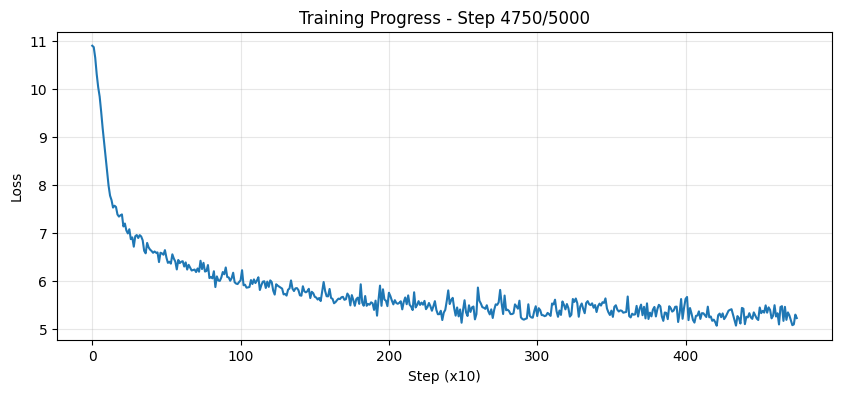

Step  4760/5000 | loss=5.0940 | lr=1.18e-05 | 1572ms
Step  4770/5000 | loss=5.1432 | lr=1.16e-05 | 1440ms
Step  4780/5000 | loss=5.1357 | lr=1.15e-05 | 1465ms
Step  4790/5000 | loss=5.2341 | lr=1.14e-05 | 1436ms
Step  4800/5000 | loss=5.3340 | lr=1.12e-05 | 1435ms
Step  4810/5000 | loss=5.4016 | lr=1.11e-05 | 1438ms
Step  4820/5000 | loss=5.4102 | lr=1.10e-05 | 1434ms
Step  4830/5000 | loss=5.0831 | lr=1.09e-05 | 1435ms
Step  4840/5000 | loss=5.2606 | lr=1.08e-05 | 1435ms
Step  4850/5000 | loss=5.2163 | lr=1.07e-05 | 1436ms
Step  4860/5000 | loss=5.2198 | lr=1.06e-05 | 1462ms
Step  4870/5000 | loss=5.2344 | lr=1.05e-05 | 1446ms
Step  4880/5000 | loss=5.2075 | lr=1.04e-05 | 1428ms
Step  4890/5000 | loss=5.2143 | lr=1.04e-05 | 1430ms
Step  4900/5000 | loss=5.3127 | lr=1.03e-05 | 1431ms
Step  4910/5000 | loss=5.2435 | lr=1.03e-05 | 1429ms
Step  4920/5000 | loss=5.1525 | lr=1.02e-05 | 1429ms
Step  4930/5000 | loss=5.3129 | lr=1.02e-05 | 1433ms
Step  4940/5000 | loss=5.1833 | lr=1.01e-05 | 

In [29]:
print("Starting training loop...")
model.train()
t0 = time.time()
running_loss = 0.0

for it in range(start_iter, max_iters):
    # Set learning rate
    lr = get_lr(it)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Gradient Accumulation
    # set_to_none=True is a speed trick (saves memory operations)
    optimizer.zero_grad(set_to_none=True)
    for micro_step in range(grad_accum_steps):
        xb, yb = next(train_loader)
        with torch.amp.autocast('cuda', dtype=torch.float16):
            logits, loss = model(xb, yb)
            loss = loss / grad_accum_steps
        # Scale the loss up so gradients don't vanish (Underflow)
        scaler.scale(loss).backward()

    # Unscale gradients back to normal size before clipping
    scaler.unscale_(optimizer)
    # Clip gradients: Make sure they aren't too huge (exploding gradients)
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update weights
    scaler.step(optimizer)
    scaler.update()

    running_loss += loss.item() * grad_accum_steps

    # Logging
    if it % 10 == 0:
        avg_loss = running_loss / 10 if it > 0 else running_loss
        losses.append(avg_loss)
        running_loss = 0.0
        dt = time.time() - t0; t0 = time.time()
        print(f"Step {it:5d}/{max_iters} | loss={avg_loss:.4f} | lr={lr:.2e} | {dt*1000:.0f}ms")

    # Plotting
    if it % eval_interval == 0 and it > 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        plt.plot(losses)
        plt.xlabel('Step (x10)')
        plt.ylabel('Loss')
        plt.title(f'Training Progress - Step {it}/{max_iters}')
        plt.grid(True, alpha=0.3)
        plt.show()

    # Saving
    if it % save_interval == 0 and it > 0:
        raw_model = model._orig_mod if hasattr(model, '_orig_mod') else model
        torch.save({
            'model': raw_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'iter': it,
            'config': config,
            'losses': losses
        }, CKPT)
        print(f"Checkpoint saved to {CKPT}")
        print("Remember to download this file if you want to keep it!")

print("Training complete.")


In [30]:
# Run this cell to DOWNLOAD your trained model to your computer.
from google.colab import files

if os.path.exists(CKPT):
    print(f"Downloading {CKPT}...")
    files.download(CKPT)
else:
    print("No checkpoint found to download!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Section Summary: Stage 6

We have successfully trained the model. It has seen millions of tokens and adjusted its weights to predict the next word.

Now comes the fun part: testing it.


## Stage 7: Inference & Chat

We will now switch the model to **Evaluation Mode** and interact with it.
We use a `temperature` parameter to control creativity:
- **Low Temperature (0.1):** Focused, deterministic, boring.
- **High Temperature (1.0):** Creative, random, sometimes crazy.


In [34]:
def chat(max_tokens=100, temp=0.8):
    model.eval()  # Turn off dropout for consistent results
    print("Chat Interface (Type 'exit' to stop)")
    print("-" * 40)
    while True:
        prompt = input("You: ")
        if prompt.lower() == 'exit': break

        # Encode prompt
        idx = tokenizer.encode(prompt).unsqueeze(0).to(device)
        print("AI: ", end="", flush=True)

        # Generate tokens one by one
        for _ in range(max_tokens):
            out = model.generate(idx, max_new=1, temperature=temp)
            new_tok = out[0, -1].item()
            print(tokenizer.decode([new_tok]), end="", flush=True)
            idx = out
        print("\n" + "-" * 40)

# Uncomment the line below to run the chat
chat()


Chat Interface (Type 'exit' to stop)
----------------------------------------
You: I love to eat and 
AI: 
Nothing is not what I do.
If I don't have a great body of attention to this condition, I don't know that so I'm a good me. The uncomfortable I would love my activity that��s ��so I don't contact them.�� The therapist says it is very tiny.
I don't know about it, but I can say that the parent can do this. So if I have any children, that will then be avoided once again.

----------------------------------------
You: today is the day of 
AI:  THE JLY CENT blamed for their efforts.
The role of animals is that the animal is an essential part of life. Two- overnight forests can be living in different properties of their own water conditions.
A dramatic increase in the deep tissue, which is the consequences of the environment for the marine system.
The reporters believe that the wild population is experiencing a physical disorder that supports the strength of the blood.
A major source of 

### Section Summary: Stage 7

You now have a working AI chatbot running on your own code.
However, you might notice it just completes sentences rather than answering questions helpfully. That's because it is a **Base Model**.

To make it an **Assistant**, we need Alignment.


## Interlude: Interpreting the Brain (Visualizing Layers)

You asked: *"What do the layers actually understand?"*

In Deep Learning theory:
- **Early Layers** (0, 1) usually focus on **Syntax** (grammar, local patterns).
- **Deep Layers** (4, 5) focus on **Semantics** (meaning, global context).

We can verify this by looking at the **Attention Maps**. We will use a "Hook" to peek inside the model while it runs.


In [ ]:
# 1. Define a Hook to capture attention weights
attention_maps = {}

def get_attention_hook(name):
    def hook(module, input, output):
        # output is the result of the block. 
        # Wait, the Block doesn't return attention weights directly in our code.
        # We need to hook into 'model.transformer.h[i].attn'
        # In our CausalSelfAttention.forward, we calculate 'y'. 
        # We didn't save 'att' (the probability matrix) in the return values.
        # This is tricky without changing the model code!
        pass
    return hook

# CRITICAL FIX: 
# Standard PyTorch hooks capture Input/Output.
# Our 'CausalSelfAttention' returns the projected output 'y', NOT the attention matrix.
# To visualize attention, we MUST modify the CausalSelfAttention class to store the weights temporarily.

# Since we cannot easily redefine the class and reload the model in the middle of a notebook run without losing weights,
# we will use a "Monkey Patch" technique or just rely on the fact that we are in a notebook and can redefine the forward pass.

# Let's redefine the forward method of the specific instance's attention module.
import types

def save_attn_forward(self, x, freqs_cis=None):
    # Copy-paste of the original forward, but saving 'att' to self.last_attn
    B, T, C = x.size()
    q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
    q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
    k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
    v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
    if freqs_cis is not None:
        q = q.transpose(1, 2); k = k.transpose(1, 2)
        q, k = apply_rotary_emb(q, k, freqs_cis)
        q = q.transpose(1, 2); k = k.transpose(1, 2)
    
    # Manual attention to get weights
    att = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
    att = att.masked_fill(torch.tril(torch.ones(T, T, device=x.device)) == 0, float('-inf'))
    att = F.softmax(att, dim=-1)
    
    # SAVE IT!
    self.last_attn_weights = att.detach() # (B, n_head, T, T)
    
    y = att @ v
    y = y.transpose(1, 2).contiguous().view(B, T, C)
    return self.dropout(self.c_proj(y))

# Apply the patch to Layer 0 (First) and Layer -1 (Last)
model.transformer.h[0].attn.forward = types.MethodType(save_attn_forward, model.transformer.h[0].attn)
model.transformer.h[-1].attn.forward = types.MethodType(save_attn_forward, model.transformer.h[-1].attn)

print("Model patched to save attention weights for visualization.")


In [ ]:
# 2. Run a test sentence
model.eval()
test_sentence = "The quick brown fox jumps over the lazy dog"
idx = tokenizer.encode(test_sentence).unsqueeze(0).to(device)
with torch.no_grad():
    model(idx)

# 3. Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Layer 0
attn0 = model.transformer.h[0].attn.last_attn_weights[0, 0].cpu().numpy() # Batch 0, Head 0
im0 = axes[0].imshow(attn0, cmap='Blues')
axes[0].set_title(f"Layer 0 (Early): Syntax/Local\n(Notice the sharp diagonal - looking at recent words)")
plt.colorbar(im0, ax=axes[0])

# Layer N
attnN = model.transformer.h[-1].attn.last_attn_weights[0, 0].cpu().numpy()
imN = axes[1].imshow(attnN, cmap='Reds')
axes[1].set_title(f"Layer {config.n_layer-1} (Deep): Semantics/Global\n(Notice the diffuse patterns - looking for meaning)")
plt.colorbar(imN, ax=axes[1])

plt.show()


## Stage 8: Instruction Fine-Tuning (SFT)

The model we trained above is a **Base Model**. It completes text, but it doesn't know how to be a helpful assistant. If you ask "What is the capital of France?", it might reply "and what is the capital of Germany?" because it thinks it's generating a list of questions.

To fix this, we perform **Supervised Fine-Tuning (SFT)**. We show it examples of Q&A and train it to follow that pattern.

We will create a tiny synthetic dataset to demonstrate this.


### 8.1 Theoretical Framework: Distribution Shift & Chat Templates

**The Problem: Pre-training vs. Instruction Following**

The Base Model approximates the probability distribution of the internet $P_{pretrain}(x)$. This distribution is high-entropy and noisy. It includes code, stories, essays, and random chatter.
When we ask a question, the model might just continue the text (e.g., by adding more questions) because that's what it saw in training data (like a forum page).

**Simple Explanation: The Etiquette Class**
The Base Model is like a wild child who just blabbers whatever comes to mind.
**SFT** is like sending it to etiquette school. We teach it:
- "When a User speaks, you listen."
- "When it's your turn, you answer helpfully."
We use special tags (like `<|im_start|>`) to mark who is speaking.

**The Mechanism: Chat Templates (Special Tokens)**

To help the model distinguish between "User" and "Assistant", we introduce **Special Control Tokens** that were not present in the pre-training data.
Common formats (like ChatML) look like this:
`<|im_start|>user\nHello<|im_end|>\n<|im_start|>assistant\nHi there!<|im_end|>`

These tokens act as "triggers" for the model to switch modes.

**Theoretical Motivation: Distribution Shift**

**Supervised Fine-Tuning (SFT)** forces a **Distribution Shift**. We want to move from $P_{pretrain}$ to $P_{assistant}$, a lower-entropy subspace where the model always acts as a helpful agent.
- The Base Model approximates the pre-training distribution $P_{pretrain}(x)$ (internet noise).
SFT forces a **Distribution Shift** to $P_{assistant}(y|x)$.
- We want to narrow the high-entropy generation space to a specific, helpful subspace.
- We use **Special Control Tokens** to condition the model on the desired role.

In [ ]:
# --- Scaffolding: Chat Templates ---
# We will manually format our data to look like a conversation.

def apply_chat_template(messages):
    # A simplified version of ChatML
    formatted = ""
    for msg in messages:
        role = msg["role"]
        content = msg["content"]
        # <|role|> content <|end|>
        formatted += f"<|{role}|>\n{content}\n<|end|>\n"
    return formatted

# Example
chat = [
    {"role": "user", "content": "Explain quantum physics."},
    {"role": "assistant", "content": "It is the study of matter and energy at the most fundamental level."}
]

print(apply_chat_template(chat))
# The model learns that after "<|user|>", it should expect a question,
# and after "<|assistant|>", it should generate an answer.


In [ ]:
# 1. Create a tiny SFT Dataset
sft_data = [
    {"role": "user", "content": "What is the capital of France?"},
    {"role": "assistant", "content": "The capital of France is Paris."},
    {"role": "user", "content": "Who wrote Romeo and Juliet?"},
    {"role": "assistant", "content": "William Shakespeare wrote Romeo and Juliet."},
    {"role": "user", "content": "What is 2 + 2?"},
    {"role": "assistant", "content": "2 + 2 is 4."},
    {"role": "user", "content": "Explain AI."},
    {"role": "assistant", "content": "AI stands for Artificial Intelligence. It is the simulation of human intelligence by machines."},
]

# 2. Format the data (ChatML style)
# We use special tokens to separate user and assistant
# <|user|> ... <|assistant|> ...
def format_prompt(entry):
    if entry['role'] == 'user':
        return f"User: {entry['content']}\nAssistant: "
    else:
        return f"{entry['content']}\n"

# Combine into training examples
train_text = ""
for i in range(0, len(sft_data), 2):
    prompt = format_prompt(sft_data[i])
    response = format_prompt(sft_data[i+1])
    train_text += prompt + response

print("Training Data Sample:")
print(train_text[:200])

# Encode
sft_tokens = torch.tensor(tokenizer.encode(train_text), dtype=torch.long).to(device)


In [ ]:
# 3. Fine-Tuning Loop
# We train on this specific data for a few steps to bias the model towards this format.

print("Starting SFT...")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5) # Lower learning rate for fine-tuning

for i in range(50):
    # Simple batching (just taking the whole tiny dataset for demo)
    # In reality, you would use a proper DataLoader
    x = sft_tokens[:-1].unsqueeze(0)
    y = sft_tokens[1:].unsqueeze(0)
    
    logits, loss = model(x, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f"Step {i}: Loss {loss.item():.4f}")

print("SFT Complete.")


In [ ]:
# 4. Test the Assistant
model.eval()
prompt = "User: What is the capital of France?\nAssistant: "
idx = tokenizer.encode(prompt).unsqueeze(0).to(device)
out = model.generate(idx, max_new=10)
print(tokenizer.decode(out[0].tolist()))


### Section Summary: Stage 8

We just performed **Instruction Tuning**. By showing the model examples of how to answer questions, we shifted its behavior from "document completion" to "conversation".

In the real world (ChatGPT), this is done on millions of high-quality conversations.


## Stage 9: Alignment (RLHF & DPO)

We have a model that speaks English (Stage 6) and answers questions (Stage 8). Why do we need more?

**The Problem:** SFT models can still be toxic, hallucinate, or give bad advice. They just mimic the training data.

**The Solution:** **Reinforcement Learning from Human Feedback (RLHF)**.
Instead of just showing the model *what* to say, we let it try to answer, and then we **grade** it.

### The Pipeline
1.  **SFT:** (Done in Stage 8)
2.  **Reward Modeling:** Train a separate AI (The Judge) to rate answers from 1 to 10 based on human preferences.
3.  **PPO / DPO:** Use that Judge to train our main model to maximize its score.

*(Note: Modern models like Llama 3 often use **DPO (Direct Preference Optimization)**, which simplifies this process by skipping the separate Reward Model step, but the goal is the same.)*

### Conceptual Demo: The Reward Signal
Implementing full PPO requires complex libraries. Instead, let's simulate how a "Reward Function" guides the model.


### 9.1 Direct Preference Optimization (DPO)

**Simple Explanation: Learning from Winners**
Instead of training a separate "Judge" AI to rate answers (which is slow and complex), **DPO** uses a clever math trick.
It looks at pairs of answers: **(Winner, Loser)**.
It adjusts the model to make the **Winner** more likely and the **Loser** less likely.
It's like teaching a dog by giving a treat for good behavior and ignoring bad behavior, directly.

---

**Theoretical Motivation: The Alignment Problem**

SFT models can still hallucinate or be toxic. We need to align them with human values.
Traditionally, **RLHF (Reinforcement Learning from Human Feedback)** was used:
1.  Train a Reward Model $r(x, y)$ to predict human preference.
2.  Use PPO (Proximal Policy Optimization) to maximize reward: $\max_{\pi} \mathbb{E}[r(x, y)] - \beta \mathbb{D}_{KL}(\pi || \pi_{ref})$.

**The Modern Approach: DPO (2023)**

DPO (used in Llama 3) mathematically proves that we can skip the Reward Model step. We can optimize the policy $\pi$ *directly* on the preference data.
We have pairs of answers: a **Winning** answer ($y_w$) and a **Losing** answer ($y_l$).
We assume human preferences follow the **Bradley-Terry Model**:

$$ P(y_w \succ y_l | x) = \sigma(r^*(x, y_w) - r^*(x, y_l)) $$

DPO derives a loss function that increases the likelihood of $y_w$ and decreases $y_l$, weighted by how much the model deviates from the reference model $\pi_{ref}$:

$$ L_{DPO} = -\log \sigma \left( \beta \log \frac{\pi_{\theta}(y_w|x)}{\pi_{ref}(y_w|x)} - \beta \log \frac{\pi_{\theta}(y_l|x)}{\pi_{ref}(y_l|x)} \right) $$

This is stable, efficient, and requires no separate reward model training.


In [ ]:
# --- Scaffolding: The DPO Loss Function ---
import torch
import torch.nn.functional as F

def dpo_loss(policy_chosen_logps, policy_rejected_logps, ref_chosen_logps, ref_rejected_logps, beta=0.1):
    """
    Calculates the DPO loss.
    beta: Controls how much we deviate from the reference model (KL penalty).
    """
    # Calculate the ratio of log probabilities
    # log(pi(y|x) / ref(y|x)) = log(pi) - log(ref)
    chosen_logratios = policy_chosen_logps - ref_chosen_logps
    rejected_logratios = policy_rejected_logps - ref_rejected_logps
    
    # The DPO objective: We want chosen > rejected
    logits = chosen_logratios - rejected_logratios
    
    # Sigmoid and Log (Binary Cross Entropy equivalent)
    losses = -F.logsigmoid(beta * logits)
    
    return losses.mean()

# Conceptual Example:
# Policy is 10% sure of Winner, 20% sure of Loser (Bad!)
# Ref is 10% sure of Winner, 10% sure of Loser (Neutral)
loss = dpo_loss(
    policy_chosen_logps=torch.tensor([-2.3]), # log(0.1)
    policy_rejected_logps=torch.tensor([-1.6]), # log(0.2)
    ref_chosen_logps=torch.tensor([-2.3]),
    ref_rejected_logps=torch.tensor([-2.3])
)
print(f"DPO Loss: {loss.item():.4f}")
# The loss is high because the policy prefers the loser.


In [ ]:
def get_reward(text):
    """A dummy reward function. Real ones are complex neural networks."""
    # We reward the model for using positive words
    positive = ["happy", "good", "great", "excellent", "love", "wonderful", "amazing"]
    return sum(1 for w in positive if w in text.lower())

# RLHF Demonstration - CONCEPTUAL ONLY
# NOTE: This is just to show you what a "Reward" looks like.
# In the modern DPO approach (explained above), we don't actually write this loop.
# We just feed the "Winner/Loser" data directly to the training.

# This demo simulates how we *would* score answers if we were using the older PPO method.
print("Initializing RLHF demonstration...")
prompts = ["Today I feel", "The weather is", "My work is"]

for i in range(50):
    prompt = prompts[i % len(prompts)]
    idx = tokenizer.encode(prompt).unsqueeze(0).to(device)

    # 1. Generate multiple samples
    responses = []
    for _ in range(4):
        out = model.generate(idx, max_new=10, temperature=0.9)
        responses.append(tokenizer.decode(out[0].tolist()))

    # 2. Score them
    rewards = [get_reward(r) for r in responses]
    avg_reward = sum(rewards) / len(rewards)

    if i % 10 == 0:
        print(f"Step {i}: Average Reward = {avg_reward:.2f}")
        best_idx = rewards.index(max(rewards))
        print(f"  Best Response: {responses[best_idx]}")

print("RLHF demonstration complete.")


### Section Summary: Stage 9

Alignment is the final polish that makes AI safe and usable for products. It bridges the gap between "Smart" and "Helpful".


## Glossary

| Term | Definition |
|------|------------|
| **BPE** | Byte Pair Encoding. The method for chopping text into tokens. |
| **Logits** | The raw scores output by the model before Softmax. |
| **Softmax** | A math function that turns scores into probabilities (0 to 1). |
| **Temperature** | A setting that controls how random the model's creativity is. |
| **Epoch** | One full pass through the entire training dataset. |
| **Inference** | Using the trained model to generate text. |

---

## Conclusion

You have successfully implemented a complete GPT architecture with modern enhancements.

**Key Concepts Covered:**
- Byte Pair Encoding (BPE)
- Causal Self-Attention and Multi-Head Attention
- RMSNorm, RoPE, and SwiGLU
- Mixed-precision training and gradient accumulation

**Next steps:**
1. Train longer (100k+ steps)
2. Use larger/better datasets
3. Fine-tune on dialogue for assistant behavior
